## Programming Assignment - Bootstrap Methods - Adv. Econometrics 2

**Deadline**:  Friday 17:00 hours, 8 January 2021

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.|Dante van der Heijden|11020075|         |
|2.|Wietse Steenstra|11004487|         |
|3.|Willem Kullberg|              |         |

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:

1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.
3. We shall not engage in any other activities that will dishonestly improve my results or dishonestly improve or hurt the results of others.

## Instructions for completing and submitting the assignment
1. Submit your work in the form of (i) a Jupyter Notebook and (ii) PDF-file via Canvas assuming basic econometric knowledge, before the deadline. Your notebook should not give errors when executed with `Run All`.
2. Complete the table with the info of your group members. By submitting the Jupyter Notebook, you agree with the included declaration of originality. Do not copy work of others. This will be considered as fraud!
3. Clarify your code with comments.

## Hints
- Only use the paired bootstrap
- Work with Numpy vectors or matrices as much as possible, e.g. `np.quantile(tB_OLS,[0.05,0.95],axis=0)` returns two quantiles for the whole vector of OLS estimates
- When coding, you can reduce the running time by setting `BOOTREP=99` and reduce the number of simulations. For the final execution, please return to original values!
- For a progress bar, please install `conda install -c conda-forge tqdm` or if you don't use anaconda use can just execute `pip install tqdm`
- If you want to use plotly, please install `conda install -c plotly plotly`
- Below, you can find Python code for generating the data and doing a simulation using multicores. To use multicores, you have to install `multiprocess`: `conda install -c conda-forge multiprocess`. Otherwise, execute `pip install multiprocess`
- The idea behind multiprocess is that each CPU core receives a sample, executes the resampling and returns the results. These results will be stored in one big list, which can be analyzed after the simulation.

## Assignment 

The purpose of this assignment is for you to gain practical experience with resampling methods. You will investigate several bootstrap confidence intervals for OLS and LASSO estimators. The DGP is given by:

- $X_i \sim N(0,\Sigma)$, $\Sigma=(\sigma_{ij}) \in \mathbb{R}^{p\times p}$ with $\sigma_{ij}=\rho^{|i-j|}$, $\beta_j=0$ for $1\leq j\leq p-15$, $\beta_j=0.5$ for $p-14\leq j\leq p-10$, $\beta_j=1.5$ for $p-9\leq j \leq p-5$ $\beta_j=2.5$ for $p-4 \leq j \leq p$. 

- $\varepsilon_1,...,\varepsilon_n \sim N(0,1)$

- $y=X \beta+\varepsilon$

Let $\hat{\beta}=(X'X)^{-1}X'y$ denote the OLS estimator, while $\breve{\beta}$ denote the LASSO estimator based on minimizing
$$ \sum_{i=1}^{n} (y_i- b'X_i)^2+\alpha \sum_{j=1}^{p}|b_j|.$$
Only consider `lasso = linear_model.Lasso(alpha=0.02)`, so keep the amount of regularization fixed!

Please, briefly answer all questions below using graphs and if necessary tables.

## Import packages

In [1]:
import numpy as np
from sklearn import linear_model
# import plotly.express as px        # uncomment if you want to use plotly.express
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

## Generate Samples

In [2]:
REP = 1000                            # numer of Monte Carlo simulations
BOOTREP = 99                         # number of bootstrap replications SET BACK TO 999
n = 50
p = 25
rho = 0.6
mu = np.zeros(p)
Sigma = np.identity(p)
for i in range(p):
    for j in range(p):
        Sigma[i,j] = rho**abs(i - j)
beta = np.zeros(p)
beta[(p - 15):(p - 10)] = 0.5
beta[(p - 10):(p - 5)] = 1.5
beta[(p - 5):] = 2.5
arglist=[]
for r in tqdm(range(REP)):
    X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n)
    eps = np.random.normal(size=n)
    y = X@beta + eps
    arglist.append((r,BOOTREP,y,X))

  0%|          | 0/1000 [00:00<?, ?it/s]

## Resampling Procedure

In [19]:
def Bootstrap(args):
    (iter,BOOTREP,y,X)=args
    
    # Define OLS function
    def OLS(y,X):
        N,p = X.shape                   # number of observations and regressors
        XXi = np.linalg.inv(X.T @ X)
        b_ols = XXi @ (X.T @ y)
        res = y-X @ b_ols
        s2 = (res @ res)/(N-p)
        SE = np.sqrt(s2*np.diag(XXi))
        return b_ols,SE,res
    
    import numpy as np
    from sklearn import linear_model
    from scipy.stats import norm
    
    n,p = X.shape
    # Estimates original sample
    lasso = linear_model.Lasso(alpha=0.02)
    lasso.fit(X, y)
    b_LASSO=np.copy(lasso.coef_)
    b_OLS,b_OLS_SE,res = OLS(y,X)
    # initilize bootstrap arrays
    bB_LASSO = np.zeros((BOOTREP,p))
    bB_OLS   = np.zeros((BOOTREP,p))
    bB_OLS_SE = np.zeros((BOOTREP,p))
    tB = np.zeros((BOOTREP,p))

    np.random.seed(1)
    # balanced bootstap
    index_B=np.random.permutation(np.repeat(np.arange(n),BOOTREP)).reshape((BOOTREP,n))
    for b in range(BOOTREP):
        index = index_B[b,:]  # select the indices
        yB = np.copy(y[index])
        XB = np.copy(X[index,:])
        lasso.fit(XB, yB)
        bB_LASSO[b,:] = np.copy(lasso.coef_)
        bB_OLS[b,:], bB_OLS_SE[b,:], bres = OLS(yB, XB)
        tB[b, :] = (bB_OLS[b]-b_OLS)/bB_OLS_SE[b]
        
    se_boot_OLS = np.std(bB_OLS, axis=0)
    se_boot_LASSO = np.std(bB_LASSO, axis=0)
    
    # percentile
    q_bB_LASSO = np.quantile(bB_LASSO,[0.05,0.95],axis=0)
    q_bB_OLS   = np.quantile(bB_OLS,[0.05,0.95],axis=0)
    q_tB_OLS   = np.quantile(tB,[0.05,0.95],axis=0)

    argout = [b_LASSO,b_OLS, b_OLS_SE, se_boot_LASSO, se_boot_OLS, q_bB_LASSO, q_bB_OLS, q_tB_OLS    # add more when necessary
             ]
    return(argout)

## Execute the Simulation and get Results

In [20]:
from multiprocess import Pool
pool4 = Pool(processes=4)
result_list = list(tqdm(pool4.imap_unordered(Bootstrap, arglist), total=REP))
pool4.close()
pool4.join()

  0%|          | 0/1000 [00:00<?, ?it/s]

## Perform the Post-Processing

In [24]:
nr_methods=4                        # number of methods
                                    # 0 = percentile
                                    # 1 = SE_boot
                                    # 2 = percentile-t
                                    # 3 = BCa

# Initialize arrays
# Bootstrap regressors and SEs
b_LASSO    =np.zeros((REP,p))
b_OLS      =np.zeros((REP,p))
b_OLS_SE = np.zeros((REP,p))
se_boot_LASSO    =np.zeros((REP,p))
se_boot_OLS      =np.zeros((REP,p))

# Bootstrap upper and lower bounds for CIs
lb_boot_LASSO = np.zeros((REP,p))
ub_boot_LASSO = np.zeros((REP,p))
lb_boot_OLS = np.zeros((REP,p))
ub_boot_OLS = np.zeros((REP,p))
t_lb_boot_OLS = np.zeros((REP,p))
t_ub_boot_OLS = np.zeros((REP,p))

for r in tqdm(range(REP)):
    b_LASSO[r,:]  = result_list[r][0]
    b_OLS[r,:]    = result_list[r][1]
    b_OLS_SE[r,:] = result_list[r][2]
    se_boot_LASSO[r,:] = result_list[r][3]
    se_boot_OLS[r,:] = result_list[r][4]
    lb_boot_LASSO[r,:] = result_list[r][5][0]
    ub_boot_LASSO[r,:] = result_list[r][5][1]
    lb_boot_OLS[r,:] = result_list[r][6][0]
    ub_boot_OLS[r,:] = result_list[r][6][1]
    t_lb_boot_OLS[r,:] = result_list[r][7][0]
    t_ub_boot_OLS[r,:] = result_list[r][7][1]
    
percentile_t_lb = b_OLS - t_ub_boot_OLS*b_OLS_SE
percentile_t_ub = b_OLS - t_lb_boot_OLS*b_OLS_SE

  0%|          | 0/1000 [00:00<?, ?it/s]

50

1. Choose $n=50$, $p=25$ and $\rho=0.6$. Determine the bias and RMSE of the OLS and LASSO estimators using 1,000 Monte Carlo replications.

## Carry Out Analysis

Avg OLS bias = 0.007322085960657949, Avg Lasso bias = 0.010513097346203686
Avg OLS SE = 0.2924945626399042, Avg Lasso SE = 0.24096261146479173
Avg OLS RMSE = 0.29262223547211685, Avg Lasso RMSE = 0.24141480007263294


<AxesSubplot:>

<Figure size 7200x4800 with 0 Axes>

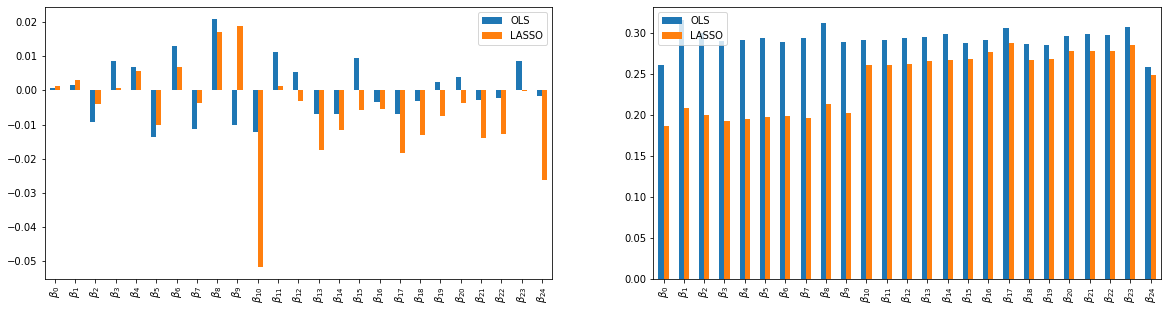

In [6]:
##### 1.
# Calculate bias for each regressor
MC_mean_OLS = np.mean(b_OLS, axis = 0)
MC_mean_LASSO = np.mean(b_LASSO, axis = 0)
MC_bias_OLS = MC_mean_OLS - beta
MC_bias_LASSO = MC_mean_LASSO - beta

# Calculate SE for each regressor
MC_SE_OLS = np.std(b_OLS, axis = 0)
MC_SE_LASSO = np.std(b_LASSO, axis = 0)

# Mean absolute bias
avg_bias_OLS = np.mean(abs(MC_bias_OLS))
avg_bias_LASSO = np.mean(abs(MC_bias_LASSO))

# Mean SE
avg_SE_OLS = np.mean(MC_SE_OLS)
avg_SE_LASSO = np.mean(MC_SE_LASSO)

RMSE_OLS = np.sqrt(np.mean((b_OLS - beta)**2, axis=0))
RMSE_LASSO = np.sqrt(np.mean((b_LASSO - beta)**2, axis=0))

print("Avg OLS bias = {0}, Avg Lasso bias = {1}".format(avg_bias_OLS,avg_bias_LASSO))
print("Avg OLS SE = {0}, Avg Lasso SE = {1}".format(avg_SE_OLS,avg_SE_LASSO))
print("Avg OLS RMSE = {0}, Avg Lasso RMSE = {1}".format(np.mean(RMSE_OLS), np.mean(RMSE_LASSO)))

# Create DFs for plots
q1_bias = pd.DataFrame({"OLS": MC_bias_OLS, "LASSO": MC_bias_LASSO})
q1_RMSE = pd.DataFrame({"OLS": RMSE_OLS, "LASSO": RMSE_LASSO})
indices = []
for i in range(len(q1_bias.index)):
    indices.append("$β_{" + str(i) + "}$")

q1_bias.index = indices
q1_RMSE.index = indices

plt.figure(dpi=1200)

fig1, axes1 = plt.subplots(1, 2, figsize=(20,5))
q1_bias.plot.bar(ax=axes1[0])
q1_RMSE.plot.bar(ax=axes1[1])

2. Estimate by simulation the coverage probabilities (cov. prob.) of the 90% first-order asymptotic two-sided confidence intervals for the OLS estimator, i.e. the fraction of confidence intervals (CI)
$$[\hat{\beta_j}-1.645 SE(\hat{\beta_j}),\hat{\beta_j}+1.645 SE(\hat{\beta_j})]$$
that contains the true parameter $\beta_j$. Here $SE(\hat{\beta_j})$ is the usual (non-robust) standard error based on $s^2(X'X)^{-1}$.

Average coverage probability = 0.8933999999999999


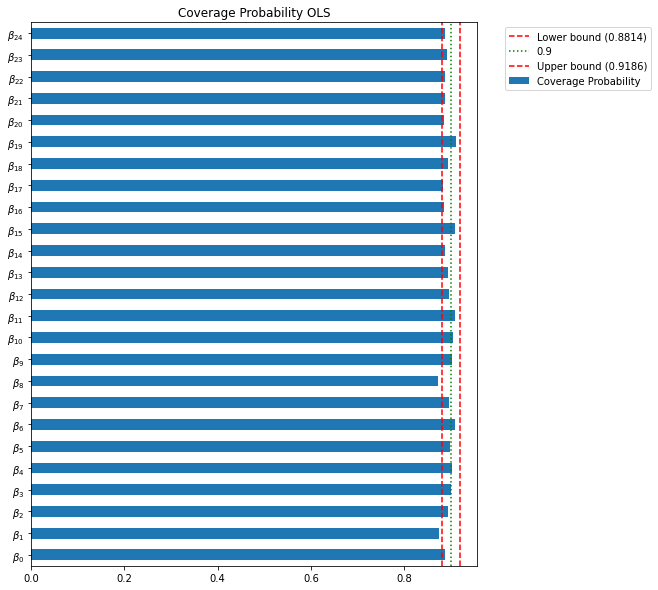

In [7]:
##### 2.
mc_ols_lb = pd.DataFrame(b_OLS) - 1.645*b_OLS_SE
mc_ols_ub = pd.DataFrame(b_OLS) + 1.645*b_OLS_SE

mc_ols_CI = mc_ols_lb.le(pd.Series(beta).T, axis=1) & mc_ols_ub.ge(pd.Series(beta).T, axis=1)
mc_ols_cov_avg_prob = np.mean(mc_ols_CI.sum()/REP)

print("Average coverage probability = {}".format(mc_ols_cov_avg_prob))

q2_CI_conv = pd.DataFrame({"Coverage Probability": (mc_ols_CI.sum()/REP)})
q2_CI_conv.index = indices
fig2, axes2 = plt.subplots(1, 1, figsize=(8,10))
(q2_CI_conv).plot.barh(ax=axes2, label="Coverage Probability")
axes2.title.set_text("Coverage Probability OLS")
axes2.axvline(x=0.8814, color='red', ls='--', label='Lower bound (0.8814)')
axes2.axvline(x=0.9, color='green', ls=':', label='0.9')
axes2.axvline(x=0.9186, color='red', ls='--', label='Upper bound (0.9186)')
axes2.legend(bbox_to_anchor=(1.05,1))

3. Estimate by simulation the cov. prob. of the 90% first-order asymptotic two-sided CI for OLS and LASSO using $$SE_{boot}(\tilde{\beta}),$$
for $$\tilde{\beta}\in \{\hat{\beta},\breve{\beta}\}.$$

Average coverage probability OLS = 0.99592
Average coverage probability LASSO = 0.9721599999999999


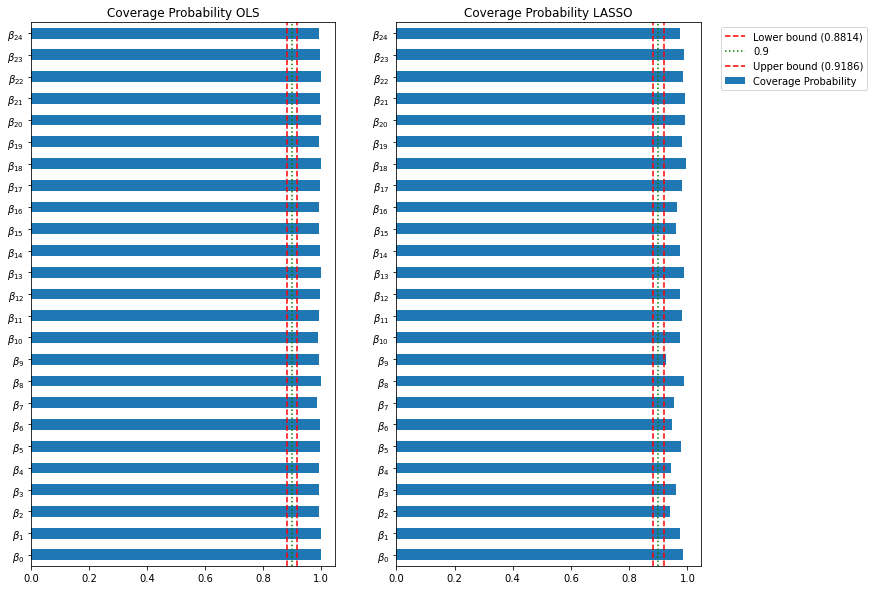

In [8]:
##### 3.
boot_ols_lb = pd.DataFrame(b_OLS) - 1.645*se_boot_OLS[0]
boot_ols_ub = pd.DataFrame(b_OLS) + 1.645*se_boot_OLS[0]
boot_lasso_lb = pd.DataFrame(b_LASSO) - 1.645*se_boot_LASSO[0]
boot_lasso_ub = pd.DataFrame(b_LASSO) + 1.645*se_boot_LASSO[0]

boot_ols_CI = boot_ols_lb.le(pd.Series(beta).T, axis=1) & boot_ols_ub.ge(pd.Series(beta).T, axis=1)
boot_ols_cov_avg_prob = np.mean(boot_ols_CI.sum()/REP)
boot_lasso_CI = boot_lasso_lb.le(pd.Series(beta).T, axis=1) & boot_lasso_ub.ge(pd.Series(beta).T, axis=1)
boot_lasso_cov_avg_prob = np.mean(boot_lasso_CI.sum()/REP)

print("Average coverage probability OLS = {}".format(boot_ols_cov_avg_prob))
print("Average coverage probability LASSO = {}".format(boot_lasso_cov_avg_prob))

q3_CI_conv_OLS = pd.DataFrame({"Coverage Probability": (boot_ols_CI.sum()/REP)})
q3_CI_conv_LASSO = pd.DataFrame({"Coverage Probability": (boot_lasso_CI.sum()/REP)})
q3_CI_conv_OLS.index = indices
q3_CI_conv_LASSO.index = indices
fig3, axes3 = plt.subplots(1, 2, figsize=(12,10))
(q3_CI_conv_OLS).plot.barh(ax=axes3[0], label="Coverage Probability")
axes3[0].title.set_text("Coverage Probability OLS")
axes3[0].axvline(x=0.8814, color='red', ls='--', label='Lower bound (0.8814)')
axes3[0].axvline(x=0.9, color='green', ls=':', label='0.9')
axes3[0].axvline(x=0.9186, color='red', ls='--', label='Upper bound (0.9186)')
axes3[0].get_legend().remove()
(q3_CI_conv_LASSO).plot.barh(ax=axes3[1], label="Coverage Probability")
axes3[1].title.set_text("Coverage Probability LASSO")
axes3[1].axvline(x=0.8814, color='red', ls='--', label='Lower bound (0.8814)')
axes3[1].axvline(x=0.9, color='green', ls=':', label='0.9')
axes3[1].axvline(x=0.9186, color='red', ls='--', label='Upper bound (0.9186)')
axes3[1].legend(bbox_to_anchor=(1.05,1))

4. Note that the cov. prob. can be interpreted as the number of successes in 1,000 trials. Hence, the estimated cov. prob. is not significantly different (at the 95% confidence level) from 90% if its value is contained in the interval
$$0.90\pm 1.96\sqrt{(0.90\times 0.10/1000)}=[0.8814,0.9186].$$
Check if the estimated cov. prob. of questions 2 & 3 are significantly different from 90%. What is your conclusion?

It is clear that the bootstrapped coverage probability is way higher than that of the non-bootstrapped. This difference is even larger between individual coverage probabilities of the parameters $\beta_i$, as noted in the graphs above. What can be noted is that the OLS estimator with bootstrapped std. errors is far superior.

However, all of the coverage probabilities from questions 2 and 3 are significantlly higher than 90%, as they all fall in the confidence interval $[0.8814,0.9186]$.

5. Estimate by simulation the cov. prob. for OLS and LASSO of 90% equal-tailed two-sided percentile bootstrap confidence intervals:
$$(\tilde{\beta}_{95\%}^*,\tilde{\beta}_{5\%}^*),$$
where $\mathbb{P}_*[\tilde{\beta}^*>\beta_{5\%}^*]=5\%$ and  $\tilde{\beta}\in \{\hat{\beta},\breve{\beta}\}$.

Average coverage probability of OLS = 0.98732
Average coverage probability LASSO = 0.9677199999999999


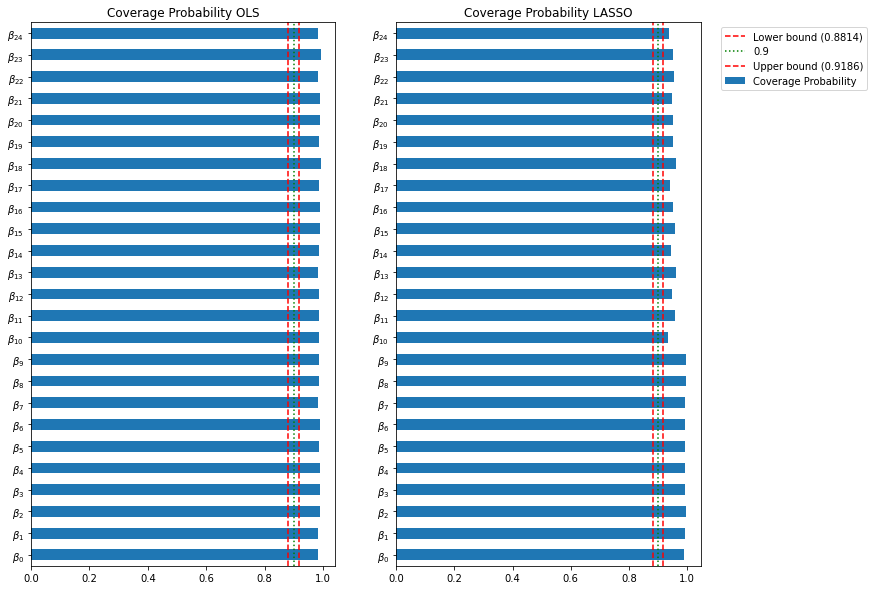

In [9]:
##### 5. 

# Create confidence intervals based on bootstrap
boot_ols_CI = pd.DataFrame(lb_boot_OLS).le(pd.Series(beta).T, axis=1) & pd.DataFrame(ub_boot_OLS).ge(pd.Series(beta).T, axis=1)
boot_lasso_CI = pd.DataFrame(lb_boot_LASSO).le(pd.Series(beta).T, axis=1) & pd.DataFrame(ub_boot_LASSO).ge(pd.Series(beta).T, axis=1)

# Calculate coverage probabalities
boot_ols_cov_avg_prob = np.mean(boot_ols_CI.sum()/REP)
boot_lasso_cov_avg_prob = np.mean(boot_lasso_CI.sum()/REP)

print("Average coverage probability of OLS = {}".format(boot_ols_cov_avg_prob))
print("Average coverage probability LASSO = {}".format(boot_lasso_cov_avg_prob))

q5_CI_conv_OLS = pd.DataFrame({"Coverage Probability": (boot_ols_CI.sum()/REP)})
q5_CI_conv_LASSO = pd.DataFrame({"Coverage Probability": (boot_lasso_CI.sum()/REP)})
q5_CI_conv_OLS.index = indices
q5_CI_conv_LASSO.index = indices
fig4, axes4 = plt.subplots(1, 2, figsize=(12,10))
(q5_CI_conv_OLS).plot.barh(ax=axes4[0], label="Coverage Probability")
axes4[0].title.set_text("Coverage Probability OLS")
axes4[0].axvline(x=0.8814, color='red', ls='--', label='Lower bound (0.8814)')
axes4[0].axvline(x=0.9, color='green', ls=':', label='0.9')
axes4[0].axvline(x=0.9186, color='red', ls='--', label='Upper bound (0.9186)')
axes4[0].get_legend().remove()
(q5_CI_conv_LASSO).plot.barh(ax=axes4[1], label="Coverage Probability")
axes4[1].title.set_text("Coverage Probability LASSO")
axes4[1].axvline(x=0.8814, color='red', ls='--', label='Lower bound (0.8814)')
axes4[1].axvline(x=0.9, color='green', ls=':', label='0.9')
axes4[1].axvline(x=0.9186, color='red', ls='--', label='Upper bound (0.9186)')
axes4[1].legend(bbox_to_anchor=(1.05,1))

6.  Estimate by simulation the cov. prob. for OLS of 90% equal-tailed two-sided percentile-$t$ bootstrap confidence intervals based on the quantiles of the root
$$(\hat{\beta}^*-\hat{\beta})/SE(\hat{\beta}^*),$$ 
where $SE(\hat{\beta}^*)$ is based on $s^{*2}(X^{*}\,' X^{*})^{-1}$.

Average coverage probability of OLS = 0.9910000000000001


,Coverage Probability
$t_{0}$,0.992
$t_{1}$,0.989
$t_{2}$,0.994
$t_{3}$,0.990
$t_{4}$,0.996
$t_{5}$,0.993
$t_{6}$,0.992
$t_{7}$,0.987
$t_{8}$,0.987
$t_{9}$,0.993


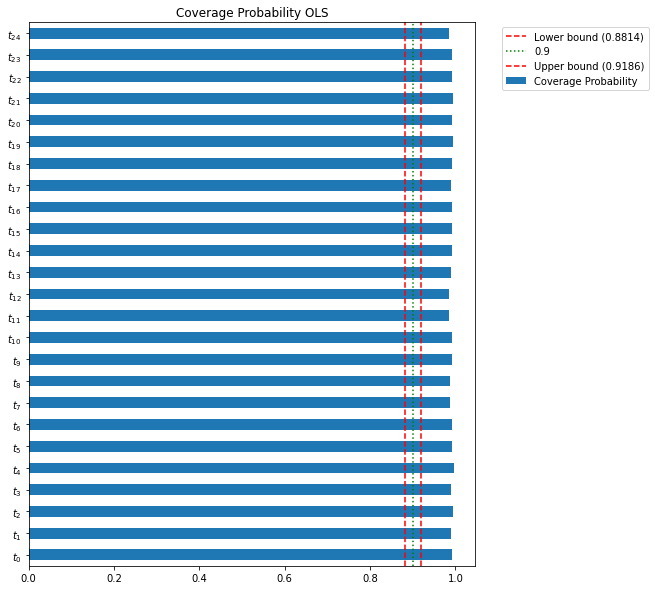

In [17]:
# Create confidence intervals based on bootstrap
t_boot_ols_CI = pd.DataFrame(percentile_t_lb).le(pd.Series(beta).T, axis=1) & pd.DataFrame(percentile_t_ub).ge(pd.Series(beta).T, axis=1)

# Calculate coverage probabalities
t_boot_ols_cov_avg_prob = np.mean(t_boot_ols_CI.sum()/REP)

print("Average coverage probability of OLS = {}".format(t_boot_ols_cov_avg_prob))

q6_CI_conv = pd.DataFrame({"Coverage Probability": (t_boot_ols_CI.sum()/REP)})
indices = []
for i in range(len(q6_CI_conv.index)):
    indices.append("$t_{" + str(i) + "}$")
q6_CI_conv.index = indices
fig5, axes5 = plt.subplots(1, 1, figsize=(8,10))
(q6_CI_conv).plot.barh(ax=axes5, label="Coverage Probability")
axes5.title.set_text("Coverage Probability OLS")
axes5.axvline(x=0.8814, color='red', ls='--', label='Lower bound (0.8814)')
axes5.axvline(x=0.9, color='green', ls=':', label='0.9')
axes5.axvline(x=0.9186, color='red', ls='--', label='Upper bound (0.9186)')
axes5.legend(bbox_to_anchor=(1.05,1))
display(q6_CI_conv)

It is clear that nearly all coverage probabilities near 1. 

7. What problems would you encounter if you wanted to implement the percentile-$t$ intervals for the LASSO? How could you remedy these problems (you don't have to implement this)?

8.  Estimate by simulation the cov. prob. for LASSO of 90% two-sided bias-corrected and accelerated (BC$_a$) confidence intervals. For this, use the bootstrap to estimate the (median) bias and the Jackknife for the acceleration constant. In the BC$_a$ method, the quantiles are adjusted:
$$\alpha_1=\Phi\left ( \hat{z}_0+\frac{\hat{z}_0+z_{\alpha/2}}{1-\hat{a}(\hat{z}_0+z_{\alpha/2})} \right ), \\
  \alpha_2=\Phi\left ( \hat{z}_0+\frac{\hat{z}_0+z_{1-\alpha}}{1-\hat{a}(\hat{z}_0+z_{1-\alpha/2})} \right ) \\
$$
with $z_{0.95}=1.645$. Here
$$\hat{z}_0=\Phi^{-1}\left ( \frac{\sum_{i=1}^n \mathbb{1} \{\hat{\theta}^*(b)<\hat{\theta}\}}{B} \right)$$
and
$$ \hat{a}=\frac{\sum_{i=1}^n (\hat{\theta}_{(\cdot)}-\hat{\theta}_{(i)})^3}{6\{\sum_{i=1}^n(\hat{\theta}_{(\cdot)}-\hat{\theta}_{(i)})^2\}^{3/2}}$$
with $\hat{\theta}_{(\cdot)}=\sum_{i=1}^n \hat{\theta}_{(i)}/n$; see for more details Section 14.3 of Efron, B., & Tibshirani, R. J. (1994). An introduction to the bootstrap: [link](http://www.ru.ac.bd/stat/wp-content/uploads/sites/25/2019/03/501_02_Efron_Introduction-to-the-Bootstrap.pdf)).

9. Based on all the results of this assignment, which inference procedure would you advise a practitioner that wants to conduct inference in a model described by the DGP? Motivate your recommendation.